# Deep Learning with PyTorch

Classical machine learning relies on using statistics to determine relationships between features and labels, and can be very effective for creating predictive models. However, a massive growth in the availability of data coupled with advances in the computing technology required to process it has led to the emergence of new machine learning techniques that mimic the way the brain processes information in a structure called an artificial neural network.

PyTorch is a Python-based open source machine learning framework that leverages the power of graphics processing units (GPUs) to provide a high level of performance for the processing of tensor objects, which can be visualized as multidimensional arrays. PyTorch can be used to create and train neural networks with high performance levels for deep learning tasks. 

In this notebook, we'll explore the basics of using TensorFlow to create a simple DNN to classify Fashion MNIST dataset. We'll build a neural image classifier using the Fashion MNIST dataset, the aim will be to train a network which can identify various types of clothing based on the low-resolution 28x28 pixel images in this dataset.

let's start by importing the pytorch libraries we're going to use. We will start by installing pytorch.You can do this using the pip package manager.

In [1]:
!pip3 install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


now we can import `torch` libarary and check the version, we will import other libraries later as we need them.

In [1]:
import torch
torch.__version__

'2.0.0+cu117'

To load the Fashion MNIST dataset using the torch.vision library, you can use the following code:

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data to [0,1]
transform = transforms.ToTensor()

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)

# Split the training data into validation and training sets
valid_size = 5000
train_size = len(trainset) - valid_size
trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size])

# create a training and validation data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

# Download and load the test data and create a testloader
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

We downloaded the Fashion MNIST dataset from `torchvision.datasets`, which is a mdule that provides many built-in datasets for computer vision tasks, including Fashion MNIST.

We created data loaders for training, testing, and validation sets with a batch size of 64. We splited the training set into two subsets with 5000 samples for validation and the rest for training.

`torch.utils.data.DataLoader` is a class that provides an iterable over a dataset. It can handle batching, shuffling, and multiprocessing of data loading. It can also work with both map-style and iterable-style datasets. A DataLoader takes a dataset object as an argument, and optionally a sampler, a batch size, a number of workers, and other parameters.

In [3]:
image, label = next(iter(trainloader))

image.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

The data stored for each image is a 28x28 collection of pixels. We can visually display this using the imshow() function from Matplotlib:

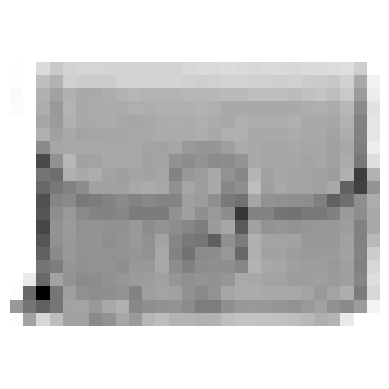

In [4]:
import matplotlib.pyplot as plt
# permute the dimensions of the image to move the color channels to the last dimension
# this is because matplotlib expects the image to be HxWxC (H=height x W=width x C=color channel), \
# while pytorch has it as the first dimension as CxHxW (C=color channel, H=height, W=width)
plt.imshow(image[1].permute(1, 2, 0).squeeze(), cmap="binary")
plt.axis('off')
plt.show()

In [5]:
class_names = trainset.dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_names[label[1]]

'Bag'

## Define a neural network



In [7]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(), # this will flatten the image batches as torch.Size([64, 784])
    
    nn.Linear(784, 256),
    nn.ReLU(),

    nn.Linear(256, 128),
    nn.ReLU(),

    nn.Linear(128, 64),
    nn.ReLU(),

    nn.Linear(64, 10)
)

## Train the model



:Once the model is created, we can check its structure using and we can put the model to train on the GPU if available.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, model.to(device)

(device(type='cuda'),
 Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=784, out_features=256, bias=True)
   (2): ReLU()
   (3): Linear(in_features=256, out_features=128, bias=True)
   (4): ReLU()
   (5): Linear(in_features=128, out_features=64, bias=True)
   (6): ReLU()
   (7): Linear(in_features=64, out_features=10, bias=True)
 ))

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

In [10]:
train_losses=[]
train_accuracy=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  num_correct=0
  num_samples=0

  for images, labels in trainloader:
    
    images, labels = images.to(device), labels.to(device)
    
    outputs=model(images)
    
    loss=criterion(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    num_samples += labels.size(0)
    num_correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accuracy=100.*num_correct/num_samples
  
  train_accuracy.append(accuracy)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accuracy))

In [11]:
val_losses=[]
val_accuracy=[]

def valid(epoch):
  model.eval()

  running_loss=0
  num_correct=0
  num_samples=0

  with torch.no_grad():
    for images, labels in validloader:
      images, labels = images.to(device), labels.to(device)
      
      outputs=model(images)

      loss= criterion(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      num_samples += labels.size(0)
      num_correct += predicted.eq(labels).sum().item()
  
  val_loss=running_loss/len(validloader)
  accuracy=100.*num_correct/num_samples

  val_losses.append(val_loss)
  val_accuracy.append(accuracy)

  print('Validation Loss: %.3f | Accuracy: %.3f'%(val_loss,accuracy)) 

In [12]:
for epoch in range(1,epochs+1): 
  train(epoch)
  valid(epoch)


Epoch : 1
Train Loss: 0.581 | Accuracy: 78.916
Validation Loss: 0.426 | Accuracy: 84.800

Epoch : 2
Train Loss: 0.392 | Accuracy: 85.640
Validation Loss: 0.363 | Accuracy: 86.400

Epoch : 3
Train Loss: 0.349 | Accuracy: 87.122
Validation Loss: 0.343 | Accuracy: 87.000

Epoch : 4
Train Loss: 0.323 | Accuracy: 88.160
Validation Loss: 0.339 | Accuracy: 87.480

Epoch : 5
Train Loss: 0.302 | Accuracy: 88.695
Validation Loss: 0.334 | Accuracy: 86.700

Epoch : 6
Train Loss: 0.286 | Accuracy: 89.420
Validation Loss: 0.307 | Accuracy: 88.880

Epoch : 7
Train Loss: 0.272 | Accuracy: 89.755
Validation Loss: 0.323 | Accuracy: 88.440

Epoch : 8
Train Loss: 0.262 | Accuracy: 90.113
Validation Loss: 0.304 | Accuracy: 89.020

Epoch : 9
Train Loss: 0.247 | Accuracy: 90.564
Validation Loss: 0.287 | Accuracy: 89.660

Epoch : 10
Train Loss: 0.240 | Accuracy: 90.835
Validation Loss: 0.289 | Accuracy: 89.540


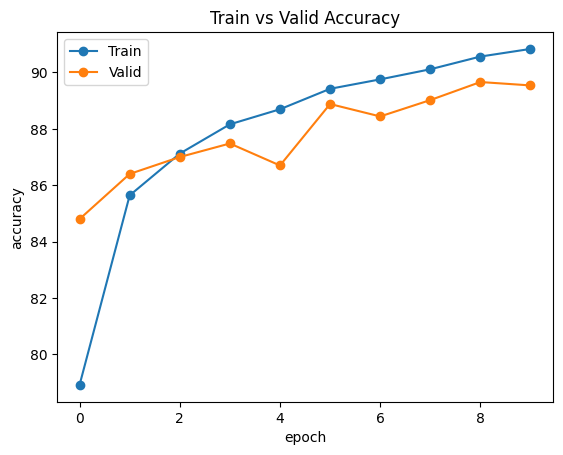

In [13]:
#plot accuracy

plt.plot(train_accuracy,'-o')
plt.plot(val_accuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

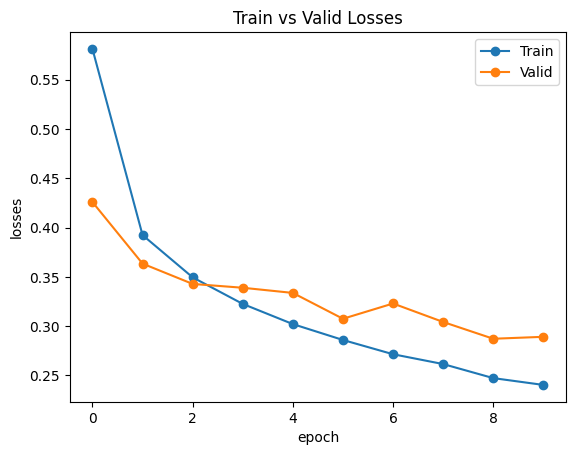

In [14]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [15]:
num_correct = 0
num_samples = 0
model.eval()

with torch.no_grad():
    for images, labels in testloader:
        images, labels =images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        num_samples += labels.size(0)
        num_correct += predicted.eq(labels).sum().item()


    accuracy=100.*num_correct/num_samples
    print(f"The accuracy of the model is {accuracy:.2f}%")

The accuracy of the model is 88.16%


## Save the trained model
Now we know the model is reasonably accurate, we can save its trained weights for use later.

In [16]:
torch.save(model, 'models/fashion-mnist-pytorch.pth')

## Learn more

This notebook was designed to help you understand the basic concepts and principles involved in deep neural networks, using a simple PyTorch example. To learn more about PyTorch, take a look at the <a href="https://pytorch.org/tutorials/" target="_blank">PyTorch Tutorials</a>.